In [1]:
import pandas as pd
import numpy as np
# from config import Config as cfg
# import pgOperation
import os
import json
# import dt
import re
import matplotlib.pyplot as plt
from PIL import Image
import sqlite3
import hashlib
import pgOperation
from sqlalchemy.types import VARCHAR, Float, Integer, Date, Numeric
pd.options.mode.chained_assignment = None


In [2]:
cnx = sqlite3.connect('./game.db')
ana = sqlite3.connect('./game_analysis.db')

## Measurement about player 

In [ ]:
sql = """
select generations, round(avg(playerScore), 2) as playerScore, count(generations) as total, max(playerScore) as max_score from ods_game_results where createtime between '2021-08-26' and '2022-12-30'
and rank = 1 and corporation2 <> '' and players = 4
group by generations;
"""


In [ ]:
# 前序表
ana.execute("drop table if exists dim_prelude;")
sql = """
    create table dim_prelude as
    select card_name, count(*)
    from (
            select *, row_number() over (partition by game_id, player) as rn
            from dwd_cards
            where corporation2 <> '') as a
    where rn = 0
    or rn = 1
    group by card_name
    having count(*) > 2
"""
ana.execute("drop table if exists dim_prelude;")

In [ ]:
# tr表
ana.execute("drop table if exists dwd_tr;")
sql = """
    create table dwd_tr as
    select a.*, lower(player) as player, tr + a.generations - 21 as increase_tr
    from (select *, row_number() over (partition by game_id, player) as rn from dwd_cards) as a
    where rn = 1;
"""
ana.execute("drop table if exists dim_prelude;")

In [ ]:
# 玩家打牌表，含卡牌类别
ana.execute("drop table if exists dwd_user_cards;")
sql = """
create table dwd_user_cards as
select *, case when b.card_name is not null then 'prelude' else 'project' end as card_type
from (select user, card_name, count(*) as total
        from (select a.*, coalesce(c.name, a.player) as user
                from dwd_cards
                        as a
                        left join ods_user_alias as c
                                on a.player = c.name
                where createtime between '2021-08-26' and '2022-12-30'
                and a.player not in ('green', '1', '2', '3', 'red', 'blue', '绿色', '红色', '黄色', '蓝色', 'yellow', '4')
        ) as a
        group by card_name, user
        having total >= 5
        order by total desc) as a
        left join dim_prelude as b
                on a.card_name = b.card_name;
"""
ana.execute("drop table if exists dim_prelude;")

In [ ]:
# 2P玩家数据
ana.execute("drop table if exists dwd_performance_2p;")
sql = """
create table dwd_performance_2p as

    with t1 as (select count(name) as player_num
                from (select name,
                             count(player)                                 as total,
                             avg(generations)                              as generations,
                             avg(playerScore)                              as playerScore,
                             avg(rank)                                     as rank,
                             (sum(rank) + 20 * 1.5) / (count(player) + 20) as bayesRank

                      from (select a.*, coalesce(b.user_name, player) as name
                            from ods_game_2022_results as a
                                     left join ods_user_alias as b
                                               on a.player = b.name
                            where createtime between '2021-08-26' and '2022-12-30'
                              and player not in
                                  ('Green', '1', '2', '3', 'Red', 'Blue', '绿色', '红色', '黄色', '蓝色', 'Yellow', '4')
                              and players = 2
                              and generations <= 15
                           ) as a
                      group by name
                      having total > 5
                      order by total desc) as a)
    select *,
           row_number() over (order by total desc)                                                             as total_rank,
           row_number() over (order by generations)                                                            as gen_rank,
           row_number() over (order by generations desc)                                                       as gen_desc_rank,
           row_number() over (order by playerScore desc)                                                       as playerScore_rank,
           row_number() over (order by rank)                                                                   as rank_rank,
           row_number() over (order by bayesRank)                                                              as bayesRank,
           row_number() over (order by increase_tr desc)                                                       as trRank,
           row_number() over (order by increase_tr)                                                            as notTrRank,
           round(row_number() over (order by bayesRank desc) / cast((select player_num from t1) as double),
                 3)                                                                                            as bayesPerc
    from (
             select name,
                    count(player)                                 as total,
                    avg(generations)                              as generations,
                    avg(playerScore)                              as playerScore,
                    avg(rank)                                     as rank,
                    (sum(rank) + 20 * 1.5) / (count(player) + 20) as bayesRank,
                    avg(increase_tr)                              as increase_tr

             from (select a.*, coalesce(b.user_name, a.player) as name, tr.increase_tr
                   from ods_game_2022_results as a
                            left join ods_user_alias as b
                                      on a.player = b.name
                            left join dwd_tr as tr
                                      on a.game_id = tr.game_id and a.player = tr.player
                   where a.createtime between '2021-08-26' and '2022-12-30'
                     and a.player not in ('Green', '1', '2', '3', 'Red', 'Blue', '绿色', '红色', '黄色', '蓝色', 'Yellow', '4')
                     and a.players = 2
                     and a.generations <= 15
                  ) as a
             group by name
             having total > 5
             order by total desc) as a;
"""
ana.execute("drop table if exists dim_prelude;")

In [ ]:
# 4P玩家数据
ana.execute("drop table if exists dwd_performance_4p;")
sql = """
create table dwd_performance_4p as

with t1 as (select count(name) as player_num
            from (
                     select name,
                            count(player)                                 as total,
                            avg(generations)                              as generations,
                            avg(playerScore)                              as playerScore,
                            avg(rank)                                     as rank,
                            (sum(rank) + 20 * 2.5) / (count(player) + 20) as bayesRank
                     from (select a.*, coalesce(b.user_name, player) as name
                           from ods_game_results as a
                                    left join ods_user_alias as b
                                              on a.player = b.name
                           where createtime between '2021-08-26' and '2022-12-30'
                             and player not in
                                 ('Green', '1', '2', '3', 'Red', 'Blue', '绿色', '红色', '黄色', '蓝色', 'Yellow', '4')
                             and players = 4
                             and generations <= 13) as a
                     group by name
                     having total > 5
                     order by total desc) as a)
select *,
       row_number() over (order by total desc)                                                             as total_rank,
       row_number() over (order by generations)                                                            as gen_rank,
       row_number() over (order by generations desc)                                                       as gen_desc_rank,
       row_number() over (order by playerScore desc)                                                       as playerScore_rank,
       row_number() over (order by rank)                                                                   as rank_rank,
       row_number() over (order by bayesRank)                                                              as bayesRank,
       row_number() over (order by increase_tr desc)                                                       as trRank,
       row_number() over (order by increase_tr)                                                            as notTrRank,
       round(row_number() over (order by bayesRank desc) / cast((select player_num from t1) as double), 3) as bayesPerc
from (
         select name,
                count(player)                                 as total,
                avg(generations)                              as generations,
                avg(playerScore)                              as playerScore,
                avg(rank)                                     as rank,
                (sum(rank) + 20 * 2.5) / (count(player) + 20) as bayesRank,
                avg(increase_tr)                              as increase_tr
         from (select a.*, coalesce(b.user_name, a.player) as name, tr.increase_tr as increase_tr
               from ods_game_results as a
                        left join ods_user_alias as b
                                  on a.player = b.name
                        left join dwd_tr as tr
                                  on a.game_id = tr.game_id and a.player = tr.player
               where a.createtime between '2021-08-26' and '2022-12-30'
                 and a.player not in ('Green', '1', '2', '3', 'Red', 'Blue', '绿色', '红色', '黄色', '蓝色', 'Yellow', '4')
                 and a.players = 4
                 and a.generations <= 13) as a
         group by name
         having total > 5
         order by total desc) as a;
"""
ana.execute("drop table if exists dim_prelude;")

## 全局指标

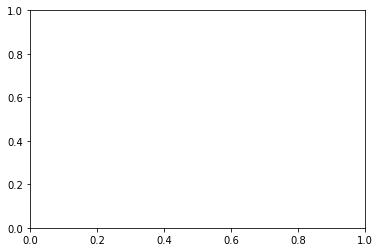

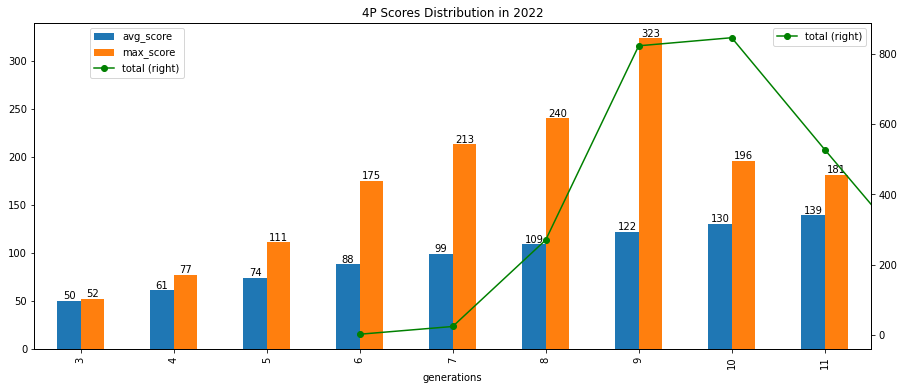

In [49]:
sql = """
        select generations,
            round(avg(playerScore), 0) as avg_score,
            count(generations)         as total,
            max(playerScore)           as max_score
        from ods_game_results
        where createtime between '2021-08-26' and '2022-12-30'
        and rank = 1
        and corporation2 <> ''
        and players = 4
        group by generations;
"""
df = pd.read_sql_query(sql, con = ana)
df.set_index('generations', inplace = True)
ax = df.plot(y = ['avg_score', 'max_score'], kind = 'bar', figsize = (15, 6), title = '4P Scores Distribution in 2022')
ax2 = ax.twinx()
df.plot(y = 'total', kind = 'line', ax = ax2, color = 'g', marker = 'o', secondary_y = True)
for container in ax.containers:
    ax.bar_label(container)

ax.legend().remove(); ax2.legend().remove(); plt.gcf().legend(loc=(0.10, 0.80))
# L = ax.legend()
# L.get_texts()[0].set_text('Average Score')
# L.get_texts()[1].set_text('Best Score')

In [40]:
df

,generations,avg_score,total,max_score
0,3,50.0,2,52
1,4,61.0,24,77
2,5,74.0,270,111
3,6,88.0,822,175
4,7,99.0,845,213
5,8,109.0,527,240
6,9,122.0,215,323
7,10,130.0,52,196
8,11,139.0,8,181


In [ ]:
def user_summary(ff1,ff2,user): ## ff1=df4
    try:
        user_df = playerGroup(ff1,4,user,player_mapping_df)
    except:
        print(user)
        return 0
    # measure 0: check whether the account is uesable
    if user_df.empty: return [''for i in range(18)]
    if pd.isna(ff2.loc[user,"createtime"].astype("int")): return [''for i in range(18)]
    # measure 1: account create date
    createtime = ff2.loc[user,"createtime"]
    # measure 1.5: first game
    firstgame = user_df.loc[0,["corporation1","rank","time"]]
    # measure 1.6 spend how many days, defeat ?% users
    # measure 2: total games, favourite corp
    group_by_corp = user_df.groupby(['corporation1']).agg({'id':'count','rank':'mean','score':'mean','generations':'mean'}).sort_values(by=['id'], ascending=False)
    group_by_corp = group_by_corp.reset_index()
    favorite_corp = group_by_corp.loc[0,'corporation1']
    favourite_corp_rank = group_by_corp.loc[0,'rank']
    favorite_corp_times = group_by_corp.loc[0,'id']
    games = user_df.shape[0]
    # measure 3: most frequently play time period
    user_df["hour"] = user_df.time.apply(lambda x: x.hour)
    group_by_hour = user_df.groupby(['hour']).agg({'id':'count','rank':'mean','score':'mean','generations':'mean'}).sort_values(by=['id'], ascending=False)
    most_freq_time = group_by_hour.reset_index().loc[0,'hour']
    # measure 4: avg score and gen, i.e. defeat 96% players (display this if the ratio > 50) TODO
    avg_rank = user_df["rank"].mean()
    avg_gens = user_df["generations"].mean()
    # measure 5: highest score, with which corp
    # highest = pd.to_numeric(user_df["score"]).idxmax()
    highest = user_df.sort_values(by=["score","generations"],ascending=[False,True])
    highest_corp = highest.iloc[0,1]
    highest_score = highest.iloc[0,4]
    highest_gens = highest.iloc[0,6]
    if (highest.iloc[0,7] != 'nan' and highest.iloc[0,7] != ''):
        highest_corp = highest_corp+' 和 '+highest.iloc[0,7]
    # measure 6: group by day. i.e 2021-06-10 seems to be a special day for u, u played 6 games by a row
    user_df["date"] = user_df["time"].dt.normalize()
    group_by_date = user_df.groupby(['date']).agg({'id':'count'}).sort_values(by=['id'], ascending=False)
    group_by_date = group_by_date[group_by_date["id"]<=7]
    played_day = group_by_date.shape[0]
    group_by_date = group_by_date.reset_index()
    most_day = group_by_date.loc[0,["date","id"]]
    # print([user, firstgame[0],firstgame[1],firstgame[2],createtime, games,favorite_corp,favorite_corp_times,most_freq_time,avg_rank,avg_gens, highest_corp, highest_score,highest_gens,played_day,most_day[0], most_day[1]])
    return [user, firstgame[0],firstgame[1],firstgame[2],createtime, games,favorite_corp,favorite_corp_times,favourite_corp_rank,most_freq_time,avg_rank,avg_gens, highest_corp, highest_score,highest_gens,played_day,most_day[0], most_day[1]]

In [ ]:
def measure_summary(ff1,ff2):
    output_df = pd.DataFrame(columns=["user_id","first_corp","first_rank","first_time","create_no","total_games","favorite_corp","fa_corp_times","fa_corp_rank","most_freq_play_time","avg_rank","avg_gens","highest_corp","highest_score","highest_gens","played_day","most_date","most_date_times"])
    for index,i in user_player.iterrows():
        # print(index)
        if (not pd.isnull(i["count"])) and i["count"]>=1 and (("tour" in index) == False):
            output_df.loc[output_df.shape[0]] = user_summary(ff1,ff2,index)
    return output_df

In [ ]:
# def measure_summary(ff1,ff2):
#     output_df = pd.DataFrame(columns=["user_id"])
#     for index,i in user_player.iterrows():
#         output_df.loc[output_df.shape[0]] = [i]
#     return output_df
# test = measure_summary(df4,user_player)
# test = test.dropna()
# test.to_csv("test.csv")

In [ ]:
output_df = measure_summary(df4,user_player)
output_df = output_df.dropna()
output_df.to_csv("measure_summary.csv")
output_df.head()

In [ ]:
output_df = pd.read_csv("measure_summary.csv")
# preprocessing
output_df = output_df[output_df["user_id"].str.contains("tour-")==False]
# play times
output_df = output_df.sort_values(by="total_games",ascending=False)
output_df['play_times_sort'] = range(1,len(output_df)+1)
# gens
output_df = output_df.sort_values(by="avg_gens",ascending=False)
output_df['gens_sort'] = range(1,len(output_df)+1)
# terraform
output_df = output_df.sort_values(by="avg_gens")
output_df['terra_sort'] = range(1,len(output_df)+1)
# terraform
output_df = output_df.sort_values(by="highest_score",ascending=False)
output_df['highest_sort'] = range(1,len(output_df)+1)
# rank
output_df["bayes_rank"] = output_df.apply(lambda x:(x["total_games"]*x["avg_rank"]+10*2.8)/(x["total_games"]+10),axis=1)
output_df = output_df.sort_values(by="bayes_rank")
output_df['rank_sort'] = range(1,len(output_df)+1)
# analyze corp ranking TODO: group by corp,ignore 'breakthrough', then find the index with the maximum values
output_df['baye_avg'] = output_df.apply(lambda x:(x["fa_corp_times"]*x["fa_corp_rank"]+5*2.5)/(x["fa_corp_times"]+5),axis=1)
output_df['max_corp'] = output_df.groupby(["favorite_corp"],as_index=False)["baye_avg"].transform(min)
output_df['max_corp'] = np.where((output_df["max_corp"]==output_df["baye_avg"]) & (output_df["baye_avg"] <= 2.5),1,0)
# output_pivot = pd.pivot_table(output_df, index=[''])
# output_df.sort_values(by="baye_avg").groupby(["favorite_corp"],as_index=False).transform(lambda x: x in range(1,len(output_df)+1))


output_df = output_df.sort_values(by="bayes_rank")
output_df.to_csv("measure_summary_sort.csv")
output_df.head()

In [ ]:
# final json file
final_df = pd.read_csv("measure_summary_sort.csv")
# entity modification
final_df[["create_no","played_day","total_games","fa_corp_times","most_freq_play_time","highest_score","highest_gens","most_date_times"]] = final_df[["create_no","played_day","total_games","fa_corp_times","most_freq_play_time","highest_score","highest_gens","most_date_times"]].astype(np.int32)
final_df["avg_rank"] = final_df["avg_rank"].round(1)
final_df["avg_gens"] = final_df["avg_gens"].round(1)
final_df[["create_time_text","first_game_text","total_game_text","favorite_corp_text","favorite_time_text","avg_rank_text","avg_gen_text","best_score_text","games_in_one_day_text","achievements"]] = final_df.apply(lambda x:('','','','','','','','','','',),axis=1,result_type='expand')
# for loop
for i,row in final_df.iterrows():
    # 1, user_id, TODO make it to be index, create_no, create_time_text
    if final_df.loc[i,"create_no"] <= 100: final_df.loc[i,"create_time_text"] = "作为登陆火星的先行者，你们为火星的建设奠定了坚实的基础！"
    elif final_df.loc[i,"create_no"] <= 805: final_df.loc[i,"create_time_text"] = "作为火星的第二批居民，你们牵引了无数小行星让火星不再孤寂寒冷。"
    else: final_df.loc[i,"create_time_text"] = "作为火星的新兴势力，感谢你们为火星增添了几分绿意！"

    # 2, first_time, first_game_text
    date_str = final_df.loc[i,"first_time"]
    final_df.loc[i,"first_time"] = date_str[0:4]+'年'+date_str[5:7]+'月'+date_str[8:10]+'日'
    if final_df.loc[i,"first_rank"].astype(np.int32) == 1: final_df.loc[i,"first_game_text"] = "崭露头角，轻取桂冠"
    elif final_df.loc[i,"first_rank"].astype(np.int32) == 2: final_df.loc[i,"first_game_text"] = "小试牛刀，施精布略"
    elif final_df.loc[i,"first_rank"].astype(np.int32) == 3: final_df.loc[i,"first_game_text"] = "初出茅庐，志在千里"
    elif final_df.loc[i,"first_rank"].astype(np.int32) == 4: final_df.loc[i,"first_game_text"] = "愈战愈勇，砥砺前行"

    # 3, played_day, total_games, total_game_text
    if final_df.loc[i,"total_games"].astype(np.int32) <= 10: final_df.loc[i,"total_game_text"] = "火星好寂寞，下次记得多陪陪人家~"
    elif final_df.loc[i,"total_games"].astype(np.int32) <= 60: final_df.loc[i,"total_game_text"] = "虽然玩得不多，但是改造委员会看到了你的诚意！"
    elif final_df.loc[i,"total_games"].astype(np.int32) <= 120: final_df.loc[i,"total_game_text"] = "改造委员会宣布你是火星年度劳模！"
    else: final_df.loc[i,"total_game_text"] = "地球办公室向你颁发感动火星十大人物证书！"

    # 4, favorite_corp, fa_corp_times
    if final_df.loc[i,"fa_corp_times"].astype(np.int32) >= 10: final_df.loc[i,"favorite_corp_text"] = "日久生情，想必彼此之间已经有羁绊了吧！"
    else: final_df.loc[i,"favorite_corp_text"] = "不要忘记和他一起度过的愉快生活哦~"

    # 5, most_freq_play_time, favorite_time_text
    if final_df.loc[i,"most_freq_play_time"].astype(np.int32) <= 14 and final_df.loc[i,"most_freq_play_time"].astype(np.int32) >= 7: final_df.loc[i,"favorite_time_text"] = "早起的火星人有牌抽！"
    elif final_df.loc[i,"most_freq_play_time"].astype(np.int32) <= 21 and final_df.loc[i,"most_freq_play_time"].astype(np.int32) > 14: final_df.loc[i,"favorite_time_text"] = "真是元气满满的火星人呢"
    else: final_df.loc[i,"favorite_time_text"] = "什么？还有不要睡觉的火星人？你是来自木星的吗？"

    # 6, avg_rank, avg_rank_text
    if final_df.loc[i,"avg_rank"] <= 2: final_df.loc[i,"avg_rank_text"] = "你是出色的技术流！世界政府需要你这样的人才！"
    elif final_df.loc[i,"avg_rank"] <= 3: final_df.loc[i,"avg_rank_text"] = "运气总是起起落落落落落落，我懂你！"
    elif final_df.loc[i,"avg_rank"] <= 4: final_df.loc[i,"avg_rank_text"] = "别灰心！4个人里面只有1个人垫底！"

    # 7, avg_gens, avg_gen_text
    if final_df.loc[i,"avg_gens"] <= 7.2: final_df.loc[i,"avg_gen_text"] = "你是纯纯粹粹的改造党，火卫二不在的第N天，想她"
    elif final_df.loc[i,"avg_gens"] <= 8: final_df.loc[i,"avg_gen_text"] = "你改造拖拖两开花，进可过牌变魔术，退可标动打工人"
    else: final_df.loc[i,"avg_gen_text"] = "你是如假包换的老拖拖，请问AI中心研究的反重力科技成果怎么样了？"

    # 8, highest_corp,highest_score,highest_gens
    if final_df.loc[i,"highest_sort"].astype(np.int32) <= 50: final_df.loc[i,"best_score_text"] = "火星吉尼斯纪录应该留下你的名字！"
    elif final_df.loc[i,"highest_sort"].astype(np.int32) <= 100: final_df.loc[i,"best_score_text"] = "金星总督向你发来祝贺。"
    else: final_df.loc[i,"best_score_text"] = "再接再厉！没事多去研究前哨所转转！"

    # 9 most_date,most_date_times
    date_str = final_df.loc[i,"first_time"]
    final_df.loc[i,"most_date"] = date_str[0:4]+'年'+date_str[5:7]+'月'+date_str[8:10]+'日'
    if final_df.loc[i,"most_date_times"].astype(np.int32) <= 1: final_df.loc[i,"games_in_one_day_text"] = "哦，原来最多也只是开了一局啊，那没事了。"
    elif final_df.loc[i,"most_date_times"].astype(np.int32) <= 3: final_df.loc[i,"games_in_one_day_text"] = "时间管理大师非你莫属！"
    else: final_df.loc[i,"games_in_one_day_text"] = "火星996说的就是你吧！"

    # achievements: play_times_sort,gens_sort,terra_sort,highest_sort,bayes_rank,rank_sort,baye_avg,max_corp
    mapping = ['零','一','二','三','四','五','六','七','八','九','十']
    operated_str = ''
    if final_df.loc[i,"play_times_sort"] <= 10: operated_str = operated_str+("国服第"+mapping[final_df.loc[i,"play_times_sort"]]+"肝帝\n")
    if final_df.loc[i,"gens_sort"] <= 10: operated_str = operated_str+("国服第"+mapping[final_df.loc[i,"gens_sort"]]+"拖拖党\n")
    if final_df.loc[i,"terra_sort"] <= 10: operated_str = operated_str+("国服第"+mapping[final_df.loc[i,"terra_sort"]]+"改造党\n")
    if final_df.loc[i,"rank_sort"] <= 10: operated_str = operated_str+("年度第"+mapping[final_df.loc[i,"rank_sort"]]+"综合实力\n")
    if final_df.loc[i,"max_corp"] == 1: operated_str = operated_str+("国服最强"+final_df.loc[i,"favorite_corp"]+"\n")

    if operated_str == '': 
        final_df.loc[i,"achievements"] = "火星打工人"
    else:
        final_df.loc[i,"achievements"] = operated_str
final_df.to_csv("measure_output.csv")
# final_df.head()

In [ ]:
final_df = final_df.loc[:,["user_id", "create_no", "create_time_text",  "first_time", "first_corp", "first_game_text", "played_day", "total_games", "total_game_text", "favorite_corp", "fa_corp_times", "fa_corp_rank", "most_freq_play_time", "favorite_time_text", "avg_rank", "avg_rank_text", "avg_gens", "avg_gen_text", "highest_corp", "highest_score", "highest_gens", "highest_sort","most_date", "most_date_times", "games_in_one_day_text", "achievements"]]

In [ ]:
json_df = final_df.set_index("user_id", drop=True)
json_df.head()
json_df.to_csv("summary.csv")
result = json_df.to_json(open("json_data7.json","w",encoding="utf-8"), orient="index", force_ascii=False)